# Natural language processing

## Importing Module

In [1]:
import os
import json
import numpy as np
import pandas as pd
import urllib

import tensorflow as tf
import tensorflow_datasets as tfds

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

print(f'Tensorflow Version : {tf.__version__}')

Tensorflow Version : 2.8.2


# PROBLEM A4

- Build and train a binary classifier for the IMDB review dataset.
The classifier should have a final layer with 1 neuron activated by sigmoid.
- Do not use lambda layers in your model.

- The dataset used in this problem is originally published in http://ai.stanford.edu/~amaas/data/sentiment/

- Desired accuracy and validation_accuracy > `83%`

### Prepare Data

In [2]:
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYEOP80/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYEOP80/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYEOP80/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

#### Split data

In [4]:
train_data, test_data = imdb['train'], imdb['test']

In [5]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [6]:
print(f'Total train data : {len(train_data)}')
print(f'Total test data : {len(test_data)}')

Total train data : 25000
Total test data : 25000


In [7]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
print(train_examples_batch)
print(train_labels_batch)

tf.Tensor(
[b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot de

### Append text and label

In [8]:
train_sentences = []
train_labels = []

test_sentences = []
test_labels = []

# DO NOT CHANGE THIS CODE
for s, l in train_data:
  train_sentences.append(s.numpy().decode('utf8'))
  train_labels.append(l.numpy())

for s, l in test_data:
  test_sentences.append(s.numpy().decode('utf8'))
  test_labels.append(l.numpy())

In [9]:
len(train_sentences), test_labels[:5]

(25000, [1, 1, 0, 0, 1])

### Set Params

In [10]:
# DO NOT CHANGE THIS CODE
# Make sure you used all of these parameters or test may fail
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'

desired_accuracy = .83

### Create Custom Callbacks

In [11]:
class MyCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epochs, logs):
            if logs.get('accuracy') > desired_accuracy and logs.get('val_accuracy') > desired_accuracy:
                print(f'\nTraining accuracy was > {desired_accuracy*100}%, stop training...')
                self.model.stop_training = True

custom_callback = MyCallback()

### Prepare the dataset for training

In [12]:
# Fit your tokenizer with training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

# Convert label to array
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [13]:
def create_model():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.Dense(6, activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"])
  
  return model

In [14]:
model = create_model()
print(f"Model : {model}")

Model : <keras.engine.sequential.Sequential object at 0x7febfb6316d0>


### Train Model

In [15]:
model.fit(padded, train_labels, 
          epochs=10,
          validation_data=(testing_padded, test_labels),
          validation_steps=30,
          callbacks=[custom_callback])

Epoch 1/10
782/782 [==============================] - 79s 93ms/step - loss: 0.5495 - accuracy: 0.6926 - val_loss: 0.3601 - val_accuracy: 0.8408
Epoch 2/10
782/782 [==============================] - ETA: 0s - loss: 0.3174 - accuracy: 0.8712
Training accuracy was > 83.0%, stop training...
782/782 [==============================] - 68s 86ms/step - loss: 0.3174 - accuracy: 0.8712 - val_loss: 0.3526 - val_accuracy: 0.8434


# PROBLEM B4

- Build and train a classifier for the BBC-text dataset.
- This is a multiclass classification problem.
- Do not use lambda layers in your model.
- The dataset used in this problem is originally published in: http://mlg.ucd.ie/datasets/bbc.html.
- Desired accuracy and validation_accuracy > `91%`

### Prepare Data

In [16]:
bbc = pd.read_csv('https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/bbc-text.csv')

bbc.head(10)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


In [17]:
print(f'Total Data : {bbc.shape[0]}')
print(f'Total Columns : {bbc.shape[1]}\n')

bbc.info()

Total Data : 2225
Total Columns : 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


#### Plot category column

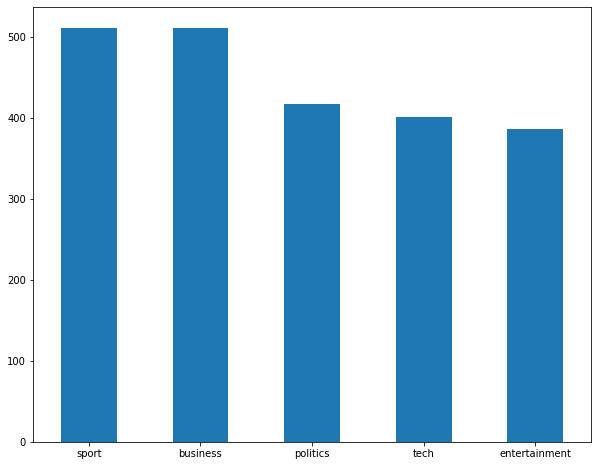

In [18]:
bbc['category'].value_counts().plot(kind='bar', figsize=(10,8), rot=0)

### Adding Stopwwords

In [19]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", 
             "an", "and", "any", "are", "as", "at", "be", "because", "been", 
             "before", "being", "below", "between", "both", "but", "by", "could"
             , "did", "do", "does", "doing", "down", "during", "each", "few", 
             "for", "from", "further", "had", "has", "have", "having", "he", 
             "he'd", "he'll", "he's", "her", "here", "here's", "hers", 
             "herself", "him", "himself", "his", "how", "how's", "i", "i'd", 
             "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", 
             "its", "itself", "let's", "me", "more", "most", "my", "myself", 
             "nor", "of", "on", "once", "only", "or", "other", "ought", "our", 
             "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", 
             "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", 
             "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", 
             "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", 
             "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", 
             "you're", "you've", "your", "yours", "yourself", "yourselves" ]

bbc['new_text'] = bbc['text'].apply((lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])))
bbc.head(10)

,category,text,new_text
0,tech,tv future in the hands of viewers with home th...,tv future hands viewers home theatre systems p...
1,business,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldcom...
2,sport,tigers wary of farrell gamble leicester say ...,tigers wary farrell gamble leicester say will ...
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle fa cup premiership side...
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...,howard hits back mongrel jibe michael howard s...
6,politics,blair prepares to name poll date tony blair is...,blair prepares name poll date tony blair likel...
7,sport,henman hopes ended in dubai third seed tim hen...,henman hopes ended dubai third seed tim henman...
8,sport,wilkinson fit to face edinburgh england captai...,wilkinson fit face edinburgh england captain j...
9,entertainment,last star wars not for children the sixth an...,last star wars not children sixth final star w...


### Encode category to number

In [20]:
bbc["label_encoding"] = bbc["category"].factorize()[0]
bbc.head(10)

,category,text,new_text,label_encoding
0,tech,tv future in the hands of viewers with home th...,tv future hands viewers home theatre systems p...,0
1,business,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldcom...,1
2,sport,tigers wary of farrell gamble leicester say ...,tigers wary farrell gamble leicester say will ...,2
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle fa cup premiership side...,2
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean s twelve raids box office ocean s twelve...,3
5,politics,howard hits back at mongrel jibe michael howar...,howard hits back mongrel jibe michael howard s...,4
6,politics,blair prepares to name poll date tony blair is...,blair prepares name poll date tony blair likel...,4
7,sport,henman hopes ended in dubai third seed tim hen...,henman hopes ended dubai third seed tim henman...,2
8,sport,wilkinson fit to face edinburgh england captai...,wilkinson fit face edinburgh england captain j...,2
9,entertainment,last star wars not for children the sixth an...,last star wars not children sixth final star w...,3


In [21]:
print(bbc['category'].value_counts())
print(bbc['label_encoding'].value_counts())

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64
2    511
1    510
4    417
0    401
3    386
Name: label_encoding, dtype: int64


### Set Parms

In [22]:
# DO NOT CHANGE THIS CODE
# Make sure you used all of these parameters or you can not pass this test
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

training_portion = .8
desired_accuracy = .91

### Split Data

In [23]:
sentences = bbc['new_text']
labels = bbc['label_encoding']

# Using "shuffle=False"
train_sentences, test_sentences, train_label, test_label = train_test_split(sentences, labels, train_size=training_portion, random_state=42, shuffle=False)

print(f'Total data training : {len(train_sentences)}')
print(f'Total data testing : {len(test_sentences)}')

Total data training : 1780
Total data testing : 445


### Create Custom Callbacks

In [24]:
class MyCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epochs, logs):
            if logs.get('accuracy') > desired_accuracy and logs.get('val_accuracy') > desired_accuracy:
                print(f'\nTraining accuracy was > {desired_accuracy*100}%, stop training...')
                self.model.stop_training = True

custom_callback = MyCallback()

### Prepare the dataset for training

In [25]:
# Fit your tokenizer with training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded  = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded  = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

In [26]:
def create_model():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
  model.add(tf.keras.layers.GlobalAveragePooling1D())
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.Dense(24, activation='relu'))
  model.add(tf.keras.layers.Dense(6, activation='softmax'))

  # Make sure you are using "sparse_categorical_crossentropy" as a loss fuction
  model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=["accuracy"])
  
  return model

In [27]:
model = create_model()
print(f"Model : {model}")

Model : <keras.engine.sequential.Sequential object at 0x7febfb88fc10>


### Train Model

In [28]:
model.fit(train_padded, train_label, 
          epochs=100,
          validation_data=(test_padded, test_label),
          validation_steps=30,
          callbacks=[custom_callback])

Epoch 1/100
56/56 [==============================] - 1s 8ms/step - loss: 1.7657 - accuracy: 0.2669 - val_loss: 1.7303 - val_accuracy: 0.4449
Epoch 2/100
56/56 [==============================] - 0s 5ms/step - loss: 1.6896 - accuracy: 0.3944 - val_loss: 1.6343 - val_accuracy: 0.4112
Epoch 3/100
56/56 [==============================] - 0s 5ms/step - loss: 1.5750 - accuracy: 0.4073 - val_loss: 1.4933 - val_accuracy: 0.4539
Epoch 4/100
56/56 [==============================] - 0s 5ms/step - loss: 1.4083 - accuracy: 0.4472 - val_loss: 1.3109 - val_accuracy: 0.4899
Epoch 5/100
56/56 [==============================] - 0s 4ms/step - loss: 1.2245 - accuracy: 0.5152 - val_loss: 1.1256 - val_accuracy: 0.6202
Epoch 6/100
56/56 [==============================] - 0s 4ms/step - loss: 1.0607 - accuracy: 0.6421 - val_loss: 0.9784 - val_accuracy: 0.7213
Epoch 7/100
56/56 [==============================] - 0s 5ms/step - loss: 0.9313 - accuracy: 0.7208 - val_loss: 0.8676 - val_accuracy: 0.7955
Epoch 8/100
5

# PROBLEM C4
- Build and train a classifier for the sarcasm dataset.
- The classifier should have a final layer with 1 neuron activated by sigmoid.
- Do not use lambda layers in your model.
- Dataset used in this problem is built by Rishabh Misra (https://rishabhmisra.github.io/publications).
- Desired accuracy and validation_accuracy > `75%`

### Prepare Data

In [29]:
data_url = 'https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/sarcasm.json'
json_file = 'sarcasm.json'

if os.path.isfile(json_file) == False:
  urllib.request.urlretrieve(data_url, json_file)
  print(f'{json_file} Downloaded')
else:
  print(f'{json_file} Already exist')

sarcasm.json Downloaded


In [30]:
json_path = './sarcasm.json'
with open(json_path, 'r') as f:
  datastore = json.load(f)

print(f'Total Data : {len(datastore)}')
print(f'List column : {datastore[0].keys()}')

Total Data : 26709
List column : dict_keys(['article_link', 'headline', 'is_sarcastic'])


In [31]:
df = pd.DataFrame(datastore)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


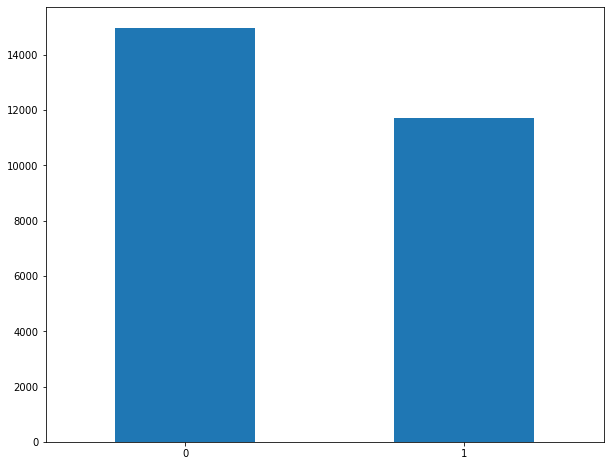

In [32]:
df['is_sarcastic'].value_counts().plot(kind='bar', figsize=(10,8), rot=0)

### Take headline and is_sarcastic column to list

In [33]:
# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

sentences = np.array(sentences)
labels = np.array(labels)

### Set Params

In [34]:
# DO NOT CHANGE THIS CODE
# Make sure you used all of these parameters or test may fail

vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 20000

desired_accuracy = .75
filter = '!"#$%&()*+.,-/:;=?@[\]^_`{|}'

### Split Data

In [35]:
train_sentences = sentences[:training_size]
train_labels = labels[:training_size]

test_sentences = sentences[training_size:]
test_labels = labels[training_size:]

print(f'Total data train: {len(train_sentences)}')
print(f'Total data test: {len(test_sentences)}')

Total data train: 20000
Total data test: 6709


### Create Custom Callbacks

In [36]:
class MyCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epochs, logs):
            if logs.get('accuracy') > desired_accuracy and logs.get('val_accuracy') > desired_accuracy:
                print(f'\nTraining accuracy was > {desired_accuracy*100}%, stop training...')
                self.model.stop_training = True

custom_callback = MyCallback()

### Prepare the dataset for training

In [37]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok, filters=filter)
tokenizer.fit_on_texts(train_sentences)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [38]:
def create_model():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
  model.add(tf.keras.layers.GlobalAveragePooling1D())
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.Dense(32, activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=["accuracy"])
  
  return model

In [39]:
model = create_model()
print(f"Model : {model}")

Model : <keras.engine.sequential.Sequential object at 0x7febfc28a790>


### Train Model

In [40]:
model.fit(train_padded, train_labels, 
          epochs=100,
          validation_data=(test_padded, test_labels),
          validation_steps=30,
          callbacks=[custom_callback])

Epoch 1/100
625/625 [==============================] - 3s 3ms/step - loss: 0.6776 - accuracy: 0.5706 - val_loss: 0.6391 - val_accuracy: 0.6031
Epoch 2/100
616/625 [============================>.] - ETA: 0s - loss: 0.5208 - accuracy: 0.7538
Training accuracy was > 75.0%, stop training...
625/625 [==============================] - 2s 3ms/step - loss: 0.5202 - accuracy: 0.7538 - val_loss: 0.4543 - val_accuracy: 0.7791
